<style>
    @media print{
        body {
            position:relative !important;
        }
        .celltag_new_page {
            page-break-before: always !important;
        }
    }
</style>
# COMPSCI 371D Homework 1

## Collaborators
- Chavez Cheong
- Khoo Qi Xuan
- Jake Heller

### Problem 0 (3 points)

## Part 1: Sets and Functions 

### Problem 1.1 (Exam Style)

$
\begin{array}{|c|c|c|c|c|c|c|c|}
	\hline
	\mbox{Domain} & \mbox{Codomain} & \mbox{Map} & \mbox{Function?} & \mbox{Injection?} & \mbox{Surjection?} & \mbox{Bijection?}
	& \mbox{None of these} \\\hline
	\{1, 2\} & \{a, b\} & \{(1, a), (1, b)\} & & & & & yes\\\hline
	\{1, 2\} & \{a, b\} & \{(1, a), (2, a)\} & yes & & & & \\\hline
	\{1, 2\} & \{a, b\} & \{(1, b), (2, a)\} & yes & yes & yes & yes & \\\hline
	\{1, 2\} & \{a, b, c\} & \{(2, a), (1, c)\} & yes & yes & & & \\\hline
	\{1, 2\} & \{b\} & \{(1, b), (2, b)\} & yes & & yes & & \\\hline
\end{array}
$

### Problem 1.2 (Exam Style)

$n(a,b) = 2^{ab} - 1$

$n(2,2) = 2^{2(2)}-1 = 2^4-1 = 15$

$n(3,3) = 2^{3(3)} - 1 = 2^9-1 = 511$

$n(2,4) = 2^{2(4)}-1 = 2^8-1 = 255$

$n(5,3) = 2^{5(3)}-1 = 2^15-1 = 32767 15$


### Problem 1.3 (Exam Style)

$n(a,b) = b^a$

$n(2,2) = 2^2 = 4$

$n(3,3) =  3^3 = 27$

$n(2,4) = 4^2 = 16$

$n(5,3) = 3^5 = 243$


### Problem 1.4 (Exam Style)

$n(a,b) = a!$ if $ a = b$, otherwise $n(a,b) = 0$

$n(2,2) = 2! = 2$

$n(3,3) =  3! = 6$

$n(2,4) = 0$

$n(5,3) = 0$

### Problem 1.5 (Exam Style)

$\text{Number of distinct training sets} = {M\choose N}2^N$

When $M = 5$, $N = 2$, $\text{number of distinct training sets} = {5\choose 2}2^2 = 10(4) = 40$

When $M = 8$, $N = 5$, $\text{number of distinct training sets} = {8\choose 5}2^5 = 56(32) = 1792$

## Part 2: Fitting Banded Linear Transformations 

### Problem 2.1

In [1]:
from urllib.request import urlretrieve
from os import path as osp


def retrieve(file_name, semester='fall21', course='371d', homework=1):
    if osp.exists(file_name):
        print('Using previously downloaded file {}'.format(file_name))
    else:
        fmt = 'https://www2.cs.duke.edu/courses/{}/compsci{}/homework/{}/{}'
        url = fmt.format(semester, course, homework, file_name)
        urlretrieve(url, file_name)
        print('Downloaded file {}'.format(file_name))


In [2]:
import pickle


def read_data(file_name):
    retrieve(file_name)
    with open(file_name, 'rb') as file:
        d = pickle.load(file)
    return d

In [3]:
data = {data_set: read_data('{}.pkl'.format(data_set))
        for data_set in ('training', 'test')}

Using previously downloaded file training.pkl
Using previously downloaded file test.pkl


In [4]:
x_tr, y_tr = data['training']['x'], data['training']['y']

In [5]:
import numpy as np


def solve_system(u, v):
    return np.linalg.lstsq(u, v, rcond=None)[0]

In [6]:
h = solve_system(x_tr, y_tr)

In [7]:
def residual(h, x, y):
    diff = np.dot(x, h) - y
    r = np.linalg.norm(diff) / np.sqrt(x.size)
    return r

In [8]:
def diagonal_indicator(d, bandwidth):
    ind = np.zeros((d, d))
    for k in range(-bandwidth, bandwidth + 1):
        length = d - np.abs(k)
        ones = np.ones(length)
        ind += np.diag(ones, k=k)
    return ind.astype(bool)

In [9]:
def un_flatten_solution(h_flat, d, bandwidth):
    indicator = diagonal_indicator(d, bandwidth)
    h = np.zeros(d * d)
    h[indicator.ravel()] = h_flat
    h = np.reshape(h, (d, d))
    return h

In [10]:
r = residual(h, x_tr, y_tr)
msg = 'The fitting residual is {:.3g}'
print(msg.format(r))

The fitting residual is 2.44e-15


In [11]:
def flatten_system(x, y, bandwidth):
    y = y.flatten()
    A = np.kron(x, np.eye(x.shape[1]))
    indicator = diagonal_indicator(x.shape[1], bandwidth).flatten()
    A = A[:, indicator]
    return A, y

In [12]:
def fit_banded_system(x, y, bandwidth):
    A, y = flatten_system(x, y, bandwidth)
    h = solve_system(A, y)
    H = un_flatten_solution(h, x.shape[1],bandwidth)
    return H

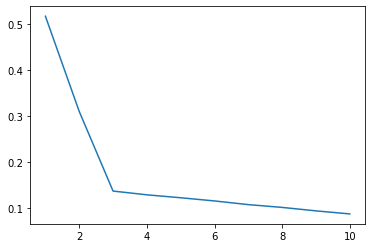

In [13]:
from matplotlib import pyplot as plt
%matplotlib inline

bandwidths = np.array(range(1,11))
errors = []
for bandwidth in bandwidths:
    h = fit_banded_system(x_tr, y_tr, bandwidth)
    errors.append(residual(h,x_tr,y_tr))
plt.plot(bandwidths, errors)
plt.show()

### Problem 2.2 (Exam Style)

This must be the case, because the larger the bandwidth, the closer we get to a full matrix, where we are not only fitting the underlying data, but also fitting the noise in the training set, hence the residual errors will continue to weakly decrease.

## Part 3: Learning Banded Linear Transformations 

### Problem 3.1

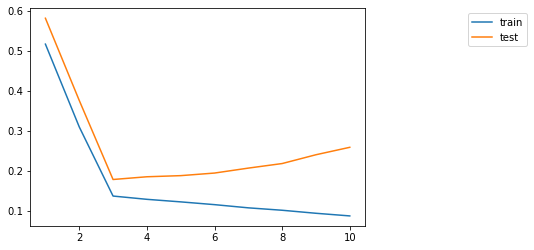

In [14]:
x_ts, y_ts = data['test']['x'], data['test']['y']

bandwidths = np.array(range(1,11))
errors_train = []
errors_test = []
for bandwidth in bandwidths:
    h = fit_banded_system(x_tr, y_tr, bandwidth)
    errors_train.append(residual(h,x_tr,y_tr))
    errors_test.append(residual(h,x_ts,y_ts))
plt.plot(bandwidths, errors_train, label = "train")
plt.plot(bandwidths, errors_test, label = "test")
plt.legend(bbox_to_anchor=(1.5,1), loc="upper right")
plt.show()

### Problem 3.2 (Exam Style)

The bandwidth used to generate the data was likely 3. We can tell this because it is at this point that the test residual reaches a minimum.

The test residual is not monotonically decreasing because as the bandwidth increases, we begin to more heavily fit the underlying training data as well as the noise, hence we run into the problem of overfitting, where the model begins to perform worse on the test data.